# EDA
* 2023/05/17  
参考URL: <https://www.kaggle.com/code/ayushs9020/understanding-the-competition-icr-eda>
train.csvのEDAはあんまり参考ならんかった  
greeks.csvについては詳しく書いてそうだったから今度確認

## コンペ概要
ICRとは、加齢に伴う健康状態の発見と診断を目的としたプロセス。  
健康診断では、病歴、身体検査、特定の検査などを総合的に評価し、健康状態を総合的に判断し、加齢に関連する状態を特定する。  
その目的は、潜在的な問題を早期に発見し、加齢に伴う健康上の懸念に適時に介入し管理すること。
ICRは、医療従事者が健康的な加齢を促進するために、予防策を調整し、個別の治療計画を策定するのを支援する。

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import StandardScaler 

In [2]:
train_data = pd.read_csv("../data/train.csv")

In [3]:
train_data.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


### データ型
* EJだけobject型

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

### EJの確認
* AとBがある
* 処理: A = 1, B=0に変換

In [5]:
train_data.EJ.value_counts()

EJ
B    395
A    222
Name: count, dtype: int64

### 欠損値の確認

In [6]:
null_counts = train_data.isnull().sum()
null_counts[null_counts!=0]

BQ    60
CB     2
CC     3
DU     1
EL    60
FC     1
FL     1
FS     2
GL     1
dtype: int64

In [9]:
train_data.Class.value_counts()

Class
0    509
1    108
Name: count, dtype: int64

# ICR competition analysis and findings
参考URL: https://www.kaggle.com/code/raddar/icr-competition-analysis-and-findings

# 1. BNは年齢

In [21]:
data = pd.read_csv("../data/train.csv")
greeks = pd.read_csv("../data/greeks.csv")

In [22]:
# dataとgreeksのキーを抽出
key = data.columns.intersection(greeks.columns).values[0]
# データフレームを結合
data = pd.merge(data, greeks, on = key)

In [4]:
data.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GF,GH,GI,GL,Class,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,2003.810319,22.136229,69.834944,0.120343,1,B,C,G,D,3/19/2019
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,27981.562750,29.135430,32.131996,21.978000,0,A,C,M,B,Unknown
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,13676.957810,28.022851,35.192676,0.196941,0,A,C,M,B,Unknown
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,2094.262452,39.948656,90.493248,0.155829,0,A,C,M,B,Unknown
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8524.370502,45.381316,36.262628,0.096614,1,D,B,F,B,3/25/2020


元データでは43歳以下だとsumが0になってるはずなんだけど、、、

In [23]:
data.groupby('BN')['Class'].agg({'count','sum'}).reset_index()

,BN,count,sum
0,9.8868,2,0
1,10.2399,2,0
2,10.5930,2,0
3,10.9461,1,0
4,11.2992,1,0
5,12.0054,1,0
6,12.3585,4,0
7,13.0647,1,0
8,13.4178,3,0
9,13.7709,3,0


BNが30以下になってるからノートブックとはデータが違う？

(array([ 4.,  3.,  1.,  5.,  1.,  3.,  8.,  2.,  7., 12., 13.,  6., 26.,
        28., 45., 53., 65., 31., 37., 42., 53., 44., 39.,  9., 26., 15.,
        12., 16.,  9.,  2.]),
 array([ 9.8868 , 10.53415, 11.1815 , 11.82885, 12.4762 , 13.12355,
        13.7709 , 14.41825, 15.0656 , 15.71295, 16.3603 , 17.00765,
        17.655  , 18.30235, 18.9497 , 19.59705, 20.2444 , 20.89175,
        21.5391 , 22.18645, 22.8338 , 23.48115, 24.1285 , 24.77585,
        25.4232 , 26.07055, 26.7179 , 27.36525, 28.0126 , 28.65995,
        29.3073 ]),
 <BarContainer object of 30 artists>)

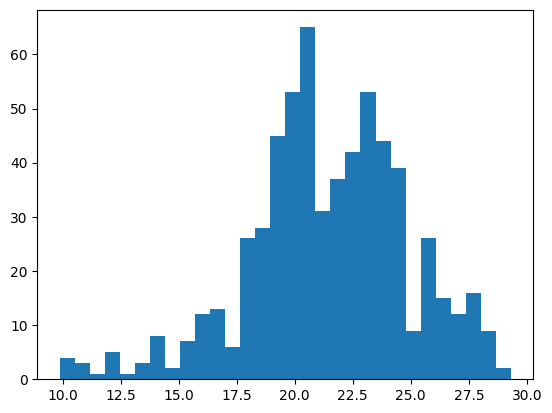

In [7]:
plt.hist(data.BN, bins=30)

### BQについて

In [8]:
# dataの中で、BQに欠損値がある列を抽出してclassでグループ化、classの個数がいくつあるか出力
data.loc[pd.isnull(data.BQ)].groupby('Class')['Class'].count().reset_index(name='n')

,Class,n
0,0,60


さらに年代別に調べると、これは無作為ではないらしい

In [9]:
# BQに欠損値がある列をEpsilonでグループ化、Epsilonの個数を出力
data.loc[pd.isnull(data.BQ)].groupby('Epsilon')['Epsilon'].count().reset_index(name='n')

,Epsilon,n
0,1/29/2019,10
1,1/31/2019,10
2,11/27/2018,2
3,2/18/2019,10
4,4/24/2019,1
5,5/27/2020,2
6,7/22/2018,1
7,Unknown,24


日付がわかっている場合、n>=10の観測を持つクラスターが３つある
## 考察
* これらの特定の日付についてはBQ欄が記録されておらず、全員がClass=0である  
→実際には検査を受けていないのではないか
* 2019-02-18以降、BQ=Noneの状況は非常に珍しいので、データドリフトの強い兆候があるため、モデルの特徴として加えるべきではないのでは

In [10]:
# Epsilonが'1/29/2019', '1/31/2029', '2/18/2019'である行の'BQ', 'Epsilon'列を抽出した後Epsilonでソート
data.loc[data.Epsilon.isin(['1/29/2019', '1/31/2029', '2/18/2019']), ['BQ', 'Epsilon']].sort_values('Epsilon')

,BQ,Epsilon
603,NaN,1/29/2019
15,NaN,1/29/2019
18,NaN,1/29/2019
46,NaN,1/29/2019
71,NaN,1/29/2019
119,NaN,1/29/2019
272,NaN,1/29/2019
281,NaN,1/29/2019
369,NaN,1/29/2019
363,NaN,1/29/2019


# 人口はEJによって区分される
EJ==Aのとき、いくつかの列は一定となる。EJは人口の36％に相当する。  
→大会主催者は2つの会場、あるいは2つの試験、あるいはそれに類するものを用意した。

In [24]:
for col in data.columns:
    # EJ==Aの行のうち、列のユニークな値が１つだけの特徴量を探す
    if len(data.loc[data.EJ=='A', col].unique()) == 1:
        print(col)

DU
EH
EJ
FD 
FL
GL


In [25]:
data.loc[data.EJ=='A',['DU','EH','EJ','FD ','FL','GL','Class', 'Epsilon']]

,DU,EH,EJ,FD,FL,GL,Class,Epsilon
1,0.005518,0.003042,A,0.29685,0.173229,21.978,0,Unknown
5,0.005518,0.003042,A,0.29685,0.173229,21.978,0,10/1/2019
9,0.005518,0.003042,A,0.29685,0.173229,21.978,0,6/19/2020
10,0.005518,0.003042,A,0.29685,0.173229,21.978,1,6/23/2020
13,0.005518,0.003042,A,0.29685,0.173229,21.978,1,9/27/2019
...,...,...,...,...,...,...,...,...
610,0.005518,0.003042,A,0.29685,0.173229,21.978,0,12/20/2018
611,0.005518,0.003042,A,0.29685,0.173229,21.978,0,6/11/2020
612,0.005518,0.003042,A,0.29685,0.173229,21.978,0,9/13/2020
614,0.005518,0.003042,A,0.29685,0.173229,21.978,0,7/24/2019


In [26]:
data.loc[data.EH==0.5].shape

(0, 63)

EJ==0のとき、EH==0.5となるため、EJを特徴量として使用する必要はない

In [27]:
data.loc[data.Epsilon.str.contains('2018')].groupby('EJ')['Class'].agg({'count', 'mean'})

,count,mean
EJ,,
A,23,0.173913
B,28,0.535714


In [28]:
data.loc[data.Epsilon.str.contains('2019')].groupby('EJ')['Class'].agg({'count', 'mean'})

,count,mean
EJ,,
A,77,0.194805
B,155,0.329032


In [29]:
data.loc[data.Epsilon.str.contains('2020')].groupby('EJ')['Class'].agg({'count', 'mean'})

,count,mean
EJ,,
A,53,0.075472
B,126,0.103175


EJ=AではEJ=Bに比べて年毎のクラスの平均値の変動がすくない

### class=1はタイムドリフトしている

In [31]:
# 年の列を作成
data['yy'] = 'Unknown'
# Epsilonから年を抽出
data.loc[data.Epsilon!='Unknown', 'yy'] = data.loc[data.Epsilon!='Unknown', 'Epsilon'].apply(lambda t: t.split('/')[2])
# 年毎のClassの数と平均値を出力
data.groupby('yy')['Class'].agg({'count', 'mean'})

,count,mean
yy,,
2012,2,0.000000
2014,7,0.571429
2016,1,1.000000
2017,1,1.000000
2018,51,0.372549
2019,232,0.284483
2020,179,0.094972
Unknown,144,0.000000


* 典型的なクロスバリデーションはモデルを検証するための有効なオプションではない
* LBフィードバックに基づいてclass_weightsを最適化するのが良い戦略かもしれない。これは筆者が確率較正を選択した場合に強く考慮すること。

# 5. Very few hard samples

最も近い20個のデータ・ポイントが他のクラスであるケースを見つける.


knn=20で、そのようなサンプルが8つあり、すべてClass=1から来ている。つまり、陽性サンプルの7％は判別が難しいデータポイントである。
(原文: 7% of the positive samples can be considered "hard")

5フォールドのクロスバリデーションをし、これらの8つのケースがフォールドに一様に分布していると仮定すると、フォールドスコアが、1つか2つの極端に難しいサンプルに大きく依存することを意味し、他のすべてのサンプルは、実際にはMLモデルで検出することがはるかに簡単。
→PublicLBでは判別が簡単な点が多い？

In [51]:
# 整数化された訓練データ（欠損値は-1で埋める
x = pd.read_csv("../data/train_integerized.csv").fillna(-1)
x.drop(['Id', 'EJ', 'Class'], axis=1, inplace=True)
# TSNE
from sklearn.manifold import TSNE
# 次元数を２に指定
tsne = TSNE(2)
tsne_result = tsne.fit_transform(x)

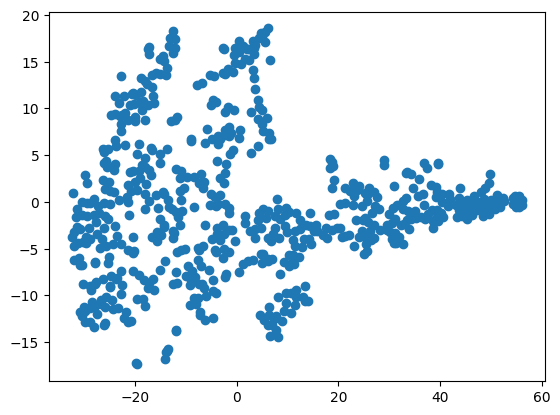

In [57]:
plt.scatter(tsne_result[:, 0], tsne_result[:, 1])

In [70]:
# 2foldでのKNN
from sklearn.neighbors import KNeighborsClassifier
knn1 = KNeighborsClassifier(20)
knn2 = KNeighborsClassifier(20)
knn_model1 = knn1.fit(tsne_result[308:, ], data['Class'][308:])
knn_model2 = knn2.fit(tsne_result[:308, ], data['Class'][:308])

# 2つのリストを連結
oof = knn_model1.predict_proba(tsne_result[:308, ])[:, 1].tolist() + knn_model2.predict_proba(tsne_result[308:, ])[:, 1].tolist()


In [63]:
res = pd.DataFrame({'prob': oof, 'class': data['Class']})
res.loc[((res['class']==0) & (res.prob==1)) | ((res['class']==1) & (res.prob==0))]

,prob,class
93,0.0,1
145,0.0,1
186,0.0,1
193,0.0,1
371,0.0,1
434,0.0,1
467,0.0,1
559,0.0,1


* ハードケースの割合が7%であることから、リーダーボードに何件のハードケースが入っているかを推定することができる。  
* テストセットには 400 件（公開 168 件、非公開 232 件）のケースがあることが分かっている。データに基づくターゲット率の減少傾向を反映するために、ターゲット率 9%（4 章を参照）を取る。その結果、公開テストセットには15件しか陽性がなく、非公開テストセットには21件しか陽性がないことがわかる。

* 15件のうち7％を取り上げると、公開テストセットでは1.05件、非公開テストセットでは1.47件のハードケースが予想される

* リーダーボードを分析すると、これまでのところ、公開テストセットには「難しい」ケースが1つ、「中程度に難しい」ケースが1つあることがわかった。

* テストセットは~2020に似ているので、もっとそれに基づいてモデルを構築すべき。この期間に基づいてclass_weightsを持つ価値があるかもしれない。
* 公開LBでオーバーライドなしでモデルをテストすることは、1-2個のデータポイントの確率を検証しているだけなので、実質的に無意味。非公開のテスト・セットにおけるこれらの1-2個のデータ・ポイントが、公開テスト・セットの「ハード」ケースと同じ分布から得られると期待するのは甘い。
* 筆者は公開LBを擬似的にラベル付けし、2段階のモデリング・アプローチを行う。